# Workshop: Generating Privacy-Preserving Synthetic Data with PrivBayes

Welcome to this hands-on workshop! In this session, we will explore privacy-preserving data generation using [PrivBayes](https://github.com/XYZ/PrivBayes), a powerful tool for creating static tabular synthetic datasets while preserving privacy. 

Imagine you are a data scientist working for a healthcare organization. You have access to a dataset containing sensitive patient information, but due to privacy regulations, you cannot share this data directly with external researchers or use it in public-facing applications. However, you still want to enable meaningful analysis and collaboration. How can you achieve this without compromising privacy?

In this workshop, you will:
1. **Generate Synthetic Data**: Use PrivBayes to create a synthetic version of a sensitive dataset. This synthetic data will retain the statistical properties of the original data while ensuring that individual records cannot be re-identified.
2. **Measure Privacy**: Evaluate the privacy guarantees of the synthetic data you produce. You will learn how to quantify privacy leakage and understand the trade-offs between data utility and privacy.

By the end of this session, you will have hands-on experience with privacy-preserving data generation techniques and a deeper understanding of how to balance privacy and utility in real-world scenarios. Let's get started by installing the required libraries:

In [ ]:
#%pip install -r requirements.txt

---
# Exercise 1: Sensitive Dataset Insight

In this session we will be working on a subset of the ALS static-vars dataset. 
Lets load the data and get some insights:


In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from IPython.display import display

# Load the dataset
real_data = pd.read_csv('Data/filtered_datasetC_train-static-vars.csv')

print("First 5 rows of the dataset:")
display(real_data.head().style.hide(axis="index"))
print("\n Number of individuals in the dataset:", len(real_data))
print("\n Description of continuous attributes:")
display(real_data.describe())

First 5 rows of the dataset:


PatientID,onsetDate,diagnosisDate,alive,sex,ethnicity,height,weight,smoking,ALS_familiar_history,occupation
0x1002e146b2dbd9369a0e4cb3942890ad,-5.866667,1.266667,False,Female,Caucasian,1.540000,57.000000,True,False,Stationary_plant_and_machine_operators
0x1017f8696f08013e167f6682bd6481ba,-22.766667,-0.466667,False,Female,Caucasian,1.600000,60.000000,True,False,Business_and_administration_professionals
0x10b5cc9f7761a4fdb587f87f423eb0c5,-19.766667,-0.500000,True,Male,Caucasian,1.670000,85.000000,True,False,Food_processing_wood_working_garment_and_other_craft_and_related_trades_workers
0x10c1b3ab36533e807507565dedf305af,-5.366667,-0.266667,False,Female,Caucasian,1.610000,64.000000,False,False,General_and_keyboard_clerks
0x1118a50ae8b4d53ca9fd81ca96b75ece,-30.233333,-0.833333,False,Male,Caucasian,1.660000,62.000000,False,True,Legal_social_and_cultural_professionals



 Number of individuals in the dataset: 915

 Description of continuous attributes:


,onsetDate,diagnosisDate,height,weight
count,915.000000,915.000000,915.000000,915.000000
mean,-13.968379,-2.300692,1.646754,67.585574
std,14.626248,9.801564,0.092956,12.863266
min,-165.333333,-162.266667,1.360000,37.000000
25%,-15.766667,-1.233333,1.580000,58.000000
50%,-10.233333,-0.700000,1.650000,67.000000
75%,-6.066667,-0.366667,1.710000,76.000000
max,13.833333,17.900000,1.980000,130.000000


Lets use t-distributed stochastic neighbor embedding (t-SNE) to visualize the dataset:

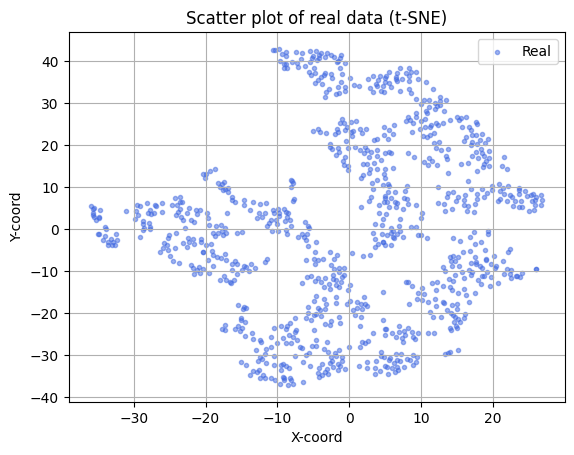

In [8]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Function to create a scatter plot of the real data using t-SNE
def scatter_plot_real_tsne(dataset):
    tsne = TSNE(n_components=2)
    coords = tsne.fit_transform(dataset)
    coords_df = pd.DataFrame(coords)
    # Scatter Plot
    plt.figure()
    # Plot DataFrame 1
    plt.scatter(coords_df[0], coords_df[1], color='royalblue',marker='.',label='Real', alpha=0.5)
    
    plt.title('Scatter plot of real data (t-SNE)')
    plt.xlabel('X-coord')
    plt.ylabel('Y-coord')
    plt.legend()
    plt.grid(True)

    return plt

encoded_real_data = pd.get_dummies(real_data) # One-hot encoding of categorical variables

# Scatter plot of real data
scatter_plot_real_tsne(encoded_real_data)
plt.show()

---
# Exercise 2: Synthesizing the Dataset with PrivBayes

In this exercise, we will use PrivBayes to generate a synthetic version of our dataset.

PrivBayes is an $\varepsilon$-differentially private synthetic data generator mechanism that synthesizes data using Bayesian networks through a three-step process:
1. **Construct Bayesian network**: it selects a Bayesian network by sampling from a distribution over possible network structures, where the probability of each structure is proportional to a Laplace-weighted scoring function (e.g., based on mutual information) evaluated on the confidential data;
2. **Make noisy conditional distributions (CPT)**: it injects Laplace noise into the CPTs to ensure differential privacy; and
3. **Synthetic data sampling**: it generates synthetic records by sequentially sampling attribute values according to the noisy conditional distributions, following the topological order of the Bayesian network.

When using PrivBayes, you will be shown information about the dataset as well as the learned Bayesian Network (BN). 
1. **Does the network logicaly make sense?**
2. **Try changing the $\varepsilon$ (epsilon) parameter.** Does increasing the $\varepsilon$-value make the dependencies in the BN more realistic? What happens when you decrease the $\varepsilon$-value?

Let's begin generating some synthetic data:

Synthetic dataset saved to 'Data/synthetic_dataset.csv'
First 5 rows of the dataset:


PatientID,onsetDate,diagnosisDate,alive,sex,ethnicity,height,weight,smoking,ALS_familiar_history,occupation
0x31c6593f7bf09c2e62e1921ea37c23f6,-7.600000,-2.733333,False,Male,Caucasian,1.750000,96.000000,True,False,Food_processing_wood_working_garment_and_other_craft_and_related_trades_workers
0x1c7b189bac7d463a7fa3c431645eb691,-20.800000,0.000000,False,Male,Caucasian,1.680000,75.000000,True,False,Cleaners_and_helpers
0x7dc10880354b50b7d5dc676ddf69d65c,-7.166667,-0.733333,True,Female,Caucasian,1.700000,60.000000,True,True,Metal_machinery_and_related_trades_workers
0x72ee3db0ddf1bdaeb8f15878c0f7114d,-7.066667,-110.733333,True,Female,Caucasian,1.650000,57.000000,False,False,General_and_keyboard_clerks
0x32050a3d2099e110aa85711a098f55df,-24.733333,-1.100000,False,Male,Caucasian,1.560000,68.000000,True,False,Legal_social_cultural_and_related_associate_professionals



 Number of individuals in the dataset: 915

 Description of continuous attributes:


,onsetDate,diagnosisDate,height,weight
count,915.0,915.000000,915.00,915.0
unique,281.0,122.000000,44.00,71.0
top,-7.6,-0.466667,1.65,65.0
freq,16.0,48.000000,60.00,52.0


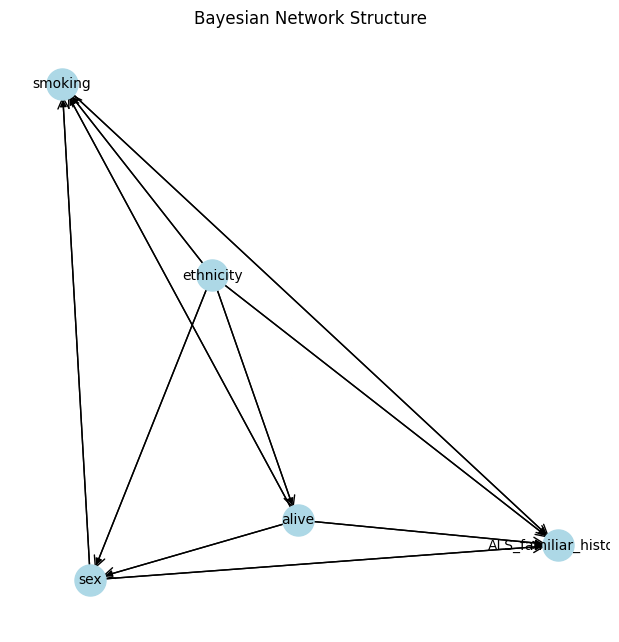

In [9]:
from synthesis.synthesizers.privbayes import PrivBayes
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
warnings.simplefilter(action='ignore', category=FutureWarning)

# Function to synthesize data
def synthesize(dataset, epsilon):
    # instantiate and fit synthesizer
    pb = PrivBayes(epsilon=epsilon, verbose=False)
    pb.fit(dataset)

    # Synthesize data
    gen_data  = pb.sample()

    edges = pb.model_.edges
    
    # Save to csv file
    syn_data = pd.DataFrame(gen_data.values, columns=gen_data.columns, index=range(dataset.shape[0]))
     
    return syn_data, edges

# Create directed graph
def bn_plot(edges):
    G = nx.DiGraph()
    G.add_edges_from(edges)
    plt.figure(figsize=(6, 6))
    pos = nx.spring_layout(G, seed=42)  # or try nx.shell_layout, nx.kamada_kawai_layout
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', arrows=True, font_size=10)
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20)
    plt.title("Bayesian Network Structure")
    plt.axis('off')
    plt.show()

# Synthesize data
synthetic_data, edges = synthesize(real_data, epsilon=10)

# Save the synthetic dataset
synthetic_data.to_csv('Data/synthetic_dataset.csv', index=False)

print("Synthetic dataset saved to 'Data/synthetic_dataset.csv'")
print("First 5 rows of the dataset:")
display(synthetic_data.head().style.hide(axis="index"))
print("\n Number of individuals in the dataset:", len(synthetic_data))
cont_attributes = ["onsetDate", "diagnosisDate", "height", "weight"]
print("\n Description of continuous attributes:")
display(synthetic_data[cont_attributes].describe())


bn_plot(edges)

---
# Exercise 3: Analysing the utility of your synthetic dataset

Let us investigate the utility of the synthetic data. 

To assist you in analysing the utility of your synthetic data, we provide the tools:
1. **t-SNE Scatter Plot**: A visualization of the high-dimensional data in a 2D space to observe the clustering and distribution of real and synthetic data points.
2. **KL-Divergence (per attribute)**: Measures how different the **categorical** distributions are between real and synthetic data for a single feature. (0 = identical distributions; higher = more divergence)
3. **Wasserstein Distance**: Measures how much the **continuous** value distributions differ (accounts for magnitude and shape). (0 = very similar; higher = more different)
4. **Correlation Difference**: The average difference in pairwise correlations between variables in the real vs synthetic datasets. (0 = same relationships; higher = structure distortion)

Utilitsing these tools;

**Try changing the $\varepsilon$-value** of the synthesize function and investigate how the change influences the utility.

Try to use the tools:

Metric,Value
KL Divergence (PatientID),6.904736
KL Divergence (alive),0.001420
KL Divergence (sex),0.002158
KL Divergence (ethnicity),0.024806
KL Divergence (smoking),0.000038
KL Divergence (ALS_familiar_history),0.000007
KL Divergence (occupation),0.146607
Wasserstein Distance (onsetDate),1.595738
Wasserstein Distance (diagnosisDate),2.328743
Wasserstein Distance (height),0.005902


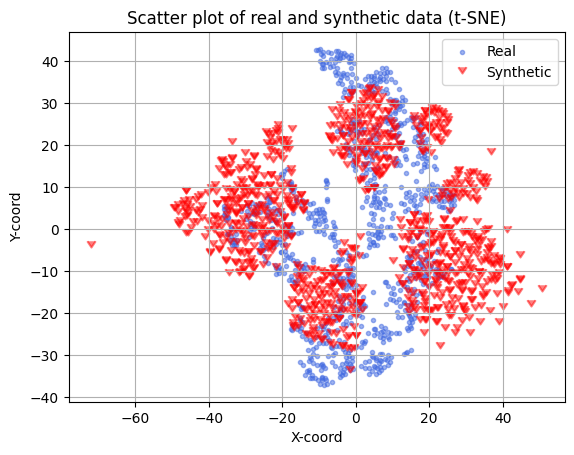

In [5]:
from scipy.stats import entropy, wasserstein_distance

# --- Detect column types
def detect_column_types(df, threshold=10):
    categorical = []
    continuous = []
    for col in df.columns:
        if df[col].dtype == object or df[col].nunique() <= threshold:
            categorical.append(col)
        else:
            continuous.append(col)
    return categorical, continuous

# --- KL divergence
def compute_kl_divergence(col, real_df, synth_df):
    p = real_df[col].value_counts(normalize=True).sort_index()
    q = synth_df[col].value_counts(normalize=True).sort_index()
    p, q = p.align(q, fill_value=1e-8)
    return entropy(p, q)

# --- Correlation difference
def pairwise_correlation_diff(df1, df2):
    corr1 = df1.corr()
    corr2 = df2.corr()
    return (corr1 - corr2).abs().mean().mean()

# --- Wasserstein distance for continuous variables
def compute_wasserstein_dist(col, real_df, synth_df):
    return wasserstein_distance(real_df[col], synth_df[col])

# --- Wrap all metrics
def compute_unsupervised_utility(real_df, synth_df):
    categorical, continuous = detect_column_types(real_df)

    kl_divs = {col: compute_kl_divergence(col, real_df, synth_df) for col in categorical}
    corr_diff = pairwise_correlation_diff(real_df[continuous], synth_df[continuous]) if continuous else None
    wass_dists = {col: compute_wasserstein_dist(col, real_df, synth_df) for col in continuous}

    return kl_divs, corr_diff, wass_dists

# --- Scatter plot of real and synthetic data
def scatter_plot_tsne(real_data, syn_data):
    tsne = TSNE(n_components=2)
    real_coords = tsne.fit_transform(real_data)
    syn_coords = tsne.fit_transform(syn_data)
    # Create DataFrames for the coordinates
    real = pd.DataFrame(real_coords)
    syn = pd.DataFrame(syn_coords)
    
    # Scatter Plot
    plt.figure()

    # Plot DataFrame 1
    plt.scatter(real[0], real[1], marker='.', color='royalblue', label='Real', alpha=0.5)

    # Plot DataFrame 2
    plt.scatter(syn[0], syn[1], marker=7,color='red', label='Synthetic', alpha=0.5)
    

    plt.title('Scatter plot of real and synthetic data (t-SNE)')
    plt.xlabel('X-coord')
    plt.ylabel('Y-coord')
    plt.legend()
    plt.grid(True)

    return plt

kl_divs, corr_diff, wass_dists = compute_unsupervised_utility(real_data, synthetic_data)

# Print clean table
results = pd.DataFrame(
    [{"Metric": f"KL Divergence ({k})", "Value": v} for k, v in kl_divs.items()] +
    [{"Metric": f"Wasserstein Distance ({k})", "Value": v} for k, v in wass_dists.items()] +
    [{"Metric": "Correlation Difference", "Value": corr_diff}]
)

display(results.style.hide(axis="index"))

encoded_synthetic_data = pd.get_dummies(synthetic_data) # One-hot encoding of categorical variables

# Scatter plot of real and synthetic data
scatter_plot_tsne(encoded_real_data, encoded_synthetic_data)
plt.show()

---
# Exercise 4: Analysing the privacy of your synthetic dataset

Let us now measure the privacy of the synthetic data using the metrics covered in the presentation. 

To assist you in analysing the privacy of your synthetic data, we provide the metrics:
1. **Attribute Inference Risk (AIR)**: Assesses how easily an attacker, using public real data and synthetic data, can infer sensitive attributes (for illustrative purposes, we've set the sensitive attribute as a binary attribute (smoking), but you can adjust this if you want to in the *sensitive_attributes.txt* file). It quantifies this difficulty with the a weighted F1-score.
2. **Distance to Closest Record (DCR)**: Measures how close each synthetic record is to its nearest real record in a 2-d space created using PCA (Smaller distances may indicate privacy risk due to overfitting or memorization).
3. **Nearest Neighbour Distance Ratio (NNDR)**: Compares the distance from a synthetic record to the nearest real vs. nearest synthetic record in a PCA derived 2-d space (Values near 0 suggest synthetic data is well-separated from real data (better privacy).
4. **Nearest Synthetic Neighbour Distance (NSND)**: Average min-max reduced distance from each real record to its nearest synthetic neighbour.

*These metrics have their score adjusted such that a score close to 1 means high risk and close to 0, no risk.*

Utilitsing these metrics try to answer the following questions;

1. **What do these results tell us?** Is the data private? How can we determine whether the data is private?
2. **Try changing the $\varepsilon$-value** of the synthesize function and investigate how the change influences the privacy.

Try to use the tools:

In [ ]:
from PrivacyMetrics import AttributeInference1 as AIR
from PrivacyMetrics import DCR
from PrivacyMetrics import NNDR
from IPython.display import clear_output

# --- Attribute Inference
def get_metric_results(real_data, synthetic_data):
    # Calculate the attribute inference metric
    air = AIR.calculate_metric(args = None, _real_data=real_data, _synthetic=synthetic_data)
    dcr = DCR.calculate_metric(args = None, _real_data=real_data, _synthetic=synthetic_data)
    nndr = NNDR.calculate_metric(args = None, _real_data=real_data, _synthetic=synthetic_data)
    # Create a dictionary to store the results
    results = {
        "AIR": air,
        "DCR": dcr,
        "NNDR": nndr
    }
    clear_output(wait=False)
    return round(pd.DataFrame(results, index=[0]), 2)

# --- Calculate the metrics
results = get_metric_results(real_data, synthetic_data)

# Display the results
print("\nPrivacy Metric Results:")
display(results.style.hide(axis="index"))




Privacy Metric Results:


AIR,DCR,NNDR,NSND
0.690000,0.750000,0.320000,0.930000


---
# Final notes: Privacy-Preserving Synthetic Data Workshop

### What We Did

- Generated synthetic datasets from real data using a **differentially private mechanism** (PrivBayes).
- Systematically varied the **privacy budget ($\varepsilon$)** to control the level of noise and privacy.
- Measured how **increasing/decreasing noise**:

  - Affects **data utility** (how useful or similar the synthetic data is).
  - Impacts **privacy guarantees** (how well individual records are protected).


### Key Insights

- **Utility–Privacy Tradeoff**:
  - Lower ε (more noise) → better privacy, but reduced statistical utility.
  - Higher ε (less noise) → more realistic synthetic data, but weaker privacy.

- **Utility Evaluation**:
  - Visualisation: t-SNE plot.
  - Utility metrics: KL divergence, correlation difference, Wasserstein distance.

- **Privacy Evaluation**:
  - Empirical metrics: AIR, DCR, NNDR, NSND.
    - Increasing noise reduces privacy leakage — but also utility.

## Takeaways

- **Synthetic data can balance utility and privacy**, but the optimal $\varepsilon$ depends on the use case.
- Evaluation should be **multi-dimensional**:
  - Statistical similarity
  - Predictive performance
  - Privacy leakage
  
- There is no single "best" $\varepsilon$ — it must align with:
  - Data sensitivity
  - Risk tolerance
  - Regulatory constraints (which you from **exercise 4** may have experienced to be quite difficult)
